In [1]:
library(tidyverse)
library(Matrix)
library(patchwork)

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [2]:
options(repr.plot.width=12, repr.plot.height=6.75)

The first-stage results are generated in `compute_ideal_points.R`

In [3]:
load("../data/correspondence_analysis.rdata")

In [4]:
str(res, max.level=1)

List of 15
 $ sv        : num [1:589] 0.797 0.576 0.473 0.428 0.389 ...
 $ nd        : num 3
 $ rownames  : chr [1:166589] "100003044" "100005598" "100006314" "10000682" ...
 $ rowmass   : num [1:166589] 3.70e-06 1.23e-05 1.07e-05 4.11e-06 2.88e-06 ...
 $ rowdist   : num [1:166589] 1.79 5.77 4.75 1.55 1.61 ...
 $ rowinertia: num [1:166589] 1.19e-05 4.11e-04 2.41e-04 9.90e-06 7.48e-06 ...
 $ rowcoord  : num [1:166589, 1:3] -0.726 -0.546 2.746 -0.571 -0.501 ...
 $ rowsup    : logi(0) 
 $ colnames  : chr [1:1760] "MH11614657" "MH11614863" "MH11615124" "MH11615431" ...
 $ colmass   : num [1:1760] 0.000107 0.000144 0.000143 0.012223 0.000459 ...
 $ coldist   : num [1:1760] 19.74 17.58 16.8 2.04 8.12 ...
 $ colinertia: num [1:1760] 0.0418 0.0446 0.0403 0.0507 0.0302 ...
 $ colcoord  : num [1:1760, 1:3] 1.46 0.837 0.347 -0.636 -0.21 ...
 $ colsup    : int [1:1170] 588 589 590 591 592 593 594 595 596 597 ...
 $ call      : language CA(obj = mat, nd = 3, supcol = non_politicians)
 - attr(*, "cl

In [5]:
elites <- read_tsv('../data/elites_combined_v2.tsv', col_types = 'fccc')

The first dimension of the ideal points, ($\phi$ in the original paper) contain most of the explanatory power, but it is worth investigating to see if the second dimension is also interesting.

In [6]:
phi <- scale(res$colcoord[,1])
phi_2 <- scale(res$colcoord[,2])

names(phi) <- res$colnames
names(phi_2) <- res$colnames

In [7]:
elites$phi <-phi[elites$meta_id]
elites$phi_2 <-phi_2[elites$meta_id]

In [8]:
mat <- readMM("../data/panel_elites_mat.mtx")

colnames(mat) <- readLines("../data/panel_elites_mat_colnames.txt")
rownames(mat) <- readLines("../data/panel_elites_mat_rownames.txt")

In [9]:
elites$followers <- colSums(mat)[elites$meta_id]

As a sanity check, compare the estimates to NOMINATE scores. The input data is the 117th Congress, but we use the NOMINATE scores for the 116th Congress and accept the missing values because the earlier scores should be more stable.

In [10]:
elites$voteview_id <- str_match(elites$meta_id, "M[SH]117(\\d+)")[,2]
dwnom <- read_csv("../data/HS116_members.csv") %>% select(nominate_dim1, nominate_dim2, icpsr, party_code) %>% mutate(voteview_id = as.character(icpsr)) %>% select(-icpsr)
elites <- elites %>% left_join(dwnom)

elites$party <- case_when(elites$party_code == 100 ~ "Democrat", elites$party_code == 200 ~ "Republican", TRUE ~ "Independent")

Parsed with column specification:
cols(
  .default = col_double(),
  chamber = col_character(),
  state_abbrev = col_character(),
  occupancy = col_logical(),
  last_means = col_logical(),
  bioname = col_character(),
  bioguide_id = col_character(),
  died = col_logical(),
  conditional = col_logical()
)

See spec(...) for full column specifications.

Joining, by = "voteview_id"



In [11]:
elites$chamber = case_when(str_sub(elites$meta_id, 2, 2) == "S" ~ "Senate", str_sub(elites$meta_id, 2, 2) == "H" ~ "House", TRUE ~ NA_character_)

In [12]:
print(cor(elites$phi, elites$nominate_dim1, use = "pairwise.complete.obs"))
print(cor(elites$phi, elites$nominate_dim2, use = "pairwise.complete.obs"))

[1] 0.9303463
[1] 0.1595854


Warning message:
“Removed 199 rows containing missing values (geom_point).”


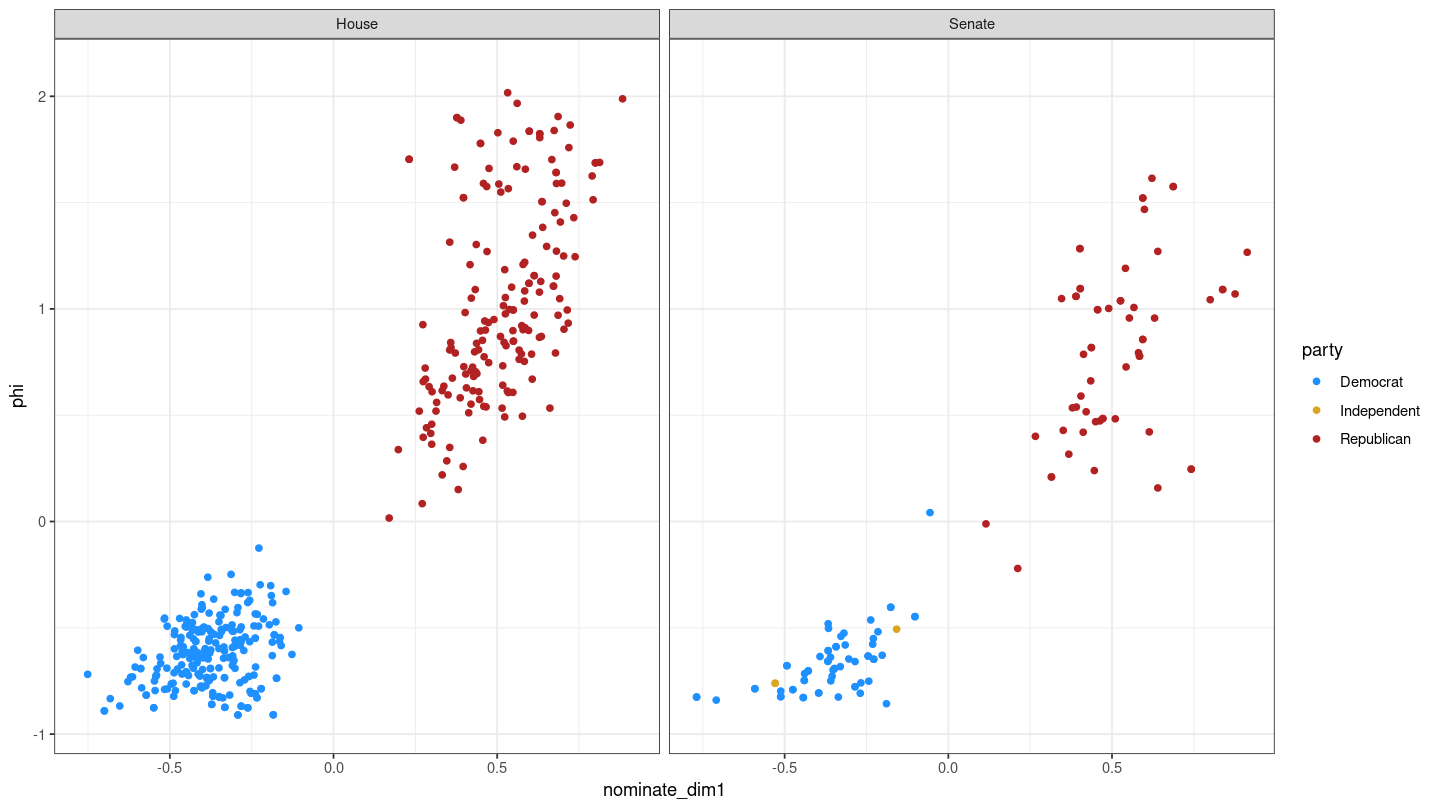

In [13]:
ggplot(elites %>% filter(!is.na(chamber)), aes(y=phi, x=nominate_dim1, color=party)) + geom_point() + theme_bw() + scale_color_manual(values=c("dodgerblue", "goldenrod", "firebrick")) + facet_wrap(vars(chamber))

The second dimension doesn't seem to have anything to do with either NOMINATE dimension.

Warning message:
“Removed 1458 rows containing missing values (geom_point).”
Warning message:
“Removed 1458 rows containing missing values (geom_point).”


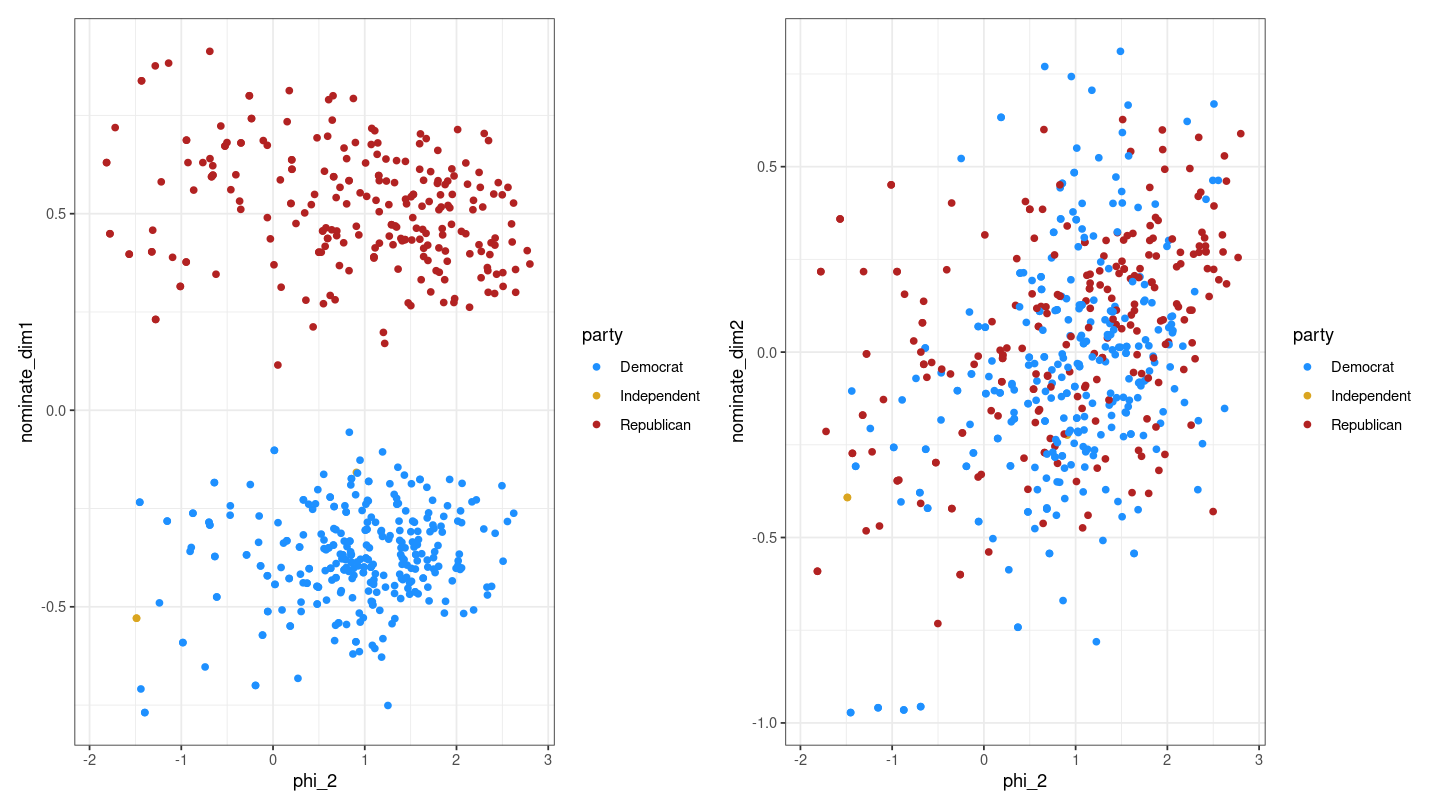

In [14]:
p1 <- ggplot(elites, aes(x=phi_2, y=nominate_dim1, color=party)) + geom_point() + theme_bw() + scale_color_manual(values=c("dodgerblue", "goldenrod", "firebrick"))
p2 <- ggplot(elites, aes(x=phi_2, y=nominate_dim2, color=party)) + geom_point() + theme_bw() + scale_color_manual(values=c("dodgerblue", "goldenrod", "firebrick"))
p1 + p2

The second dimension may have something to do with general popularity.

In [15]:
print(cor(elites$phi, elites$followers, use = "pairwise.complete.obs"))
print(cor(elites$phi_2, elites$followers, use = "pairwise.complete.obs"))

[1] -0.09024492
[1] -0.2859246


Warning message:
“Removed 69 rows containing missing values (geom_point).”


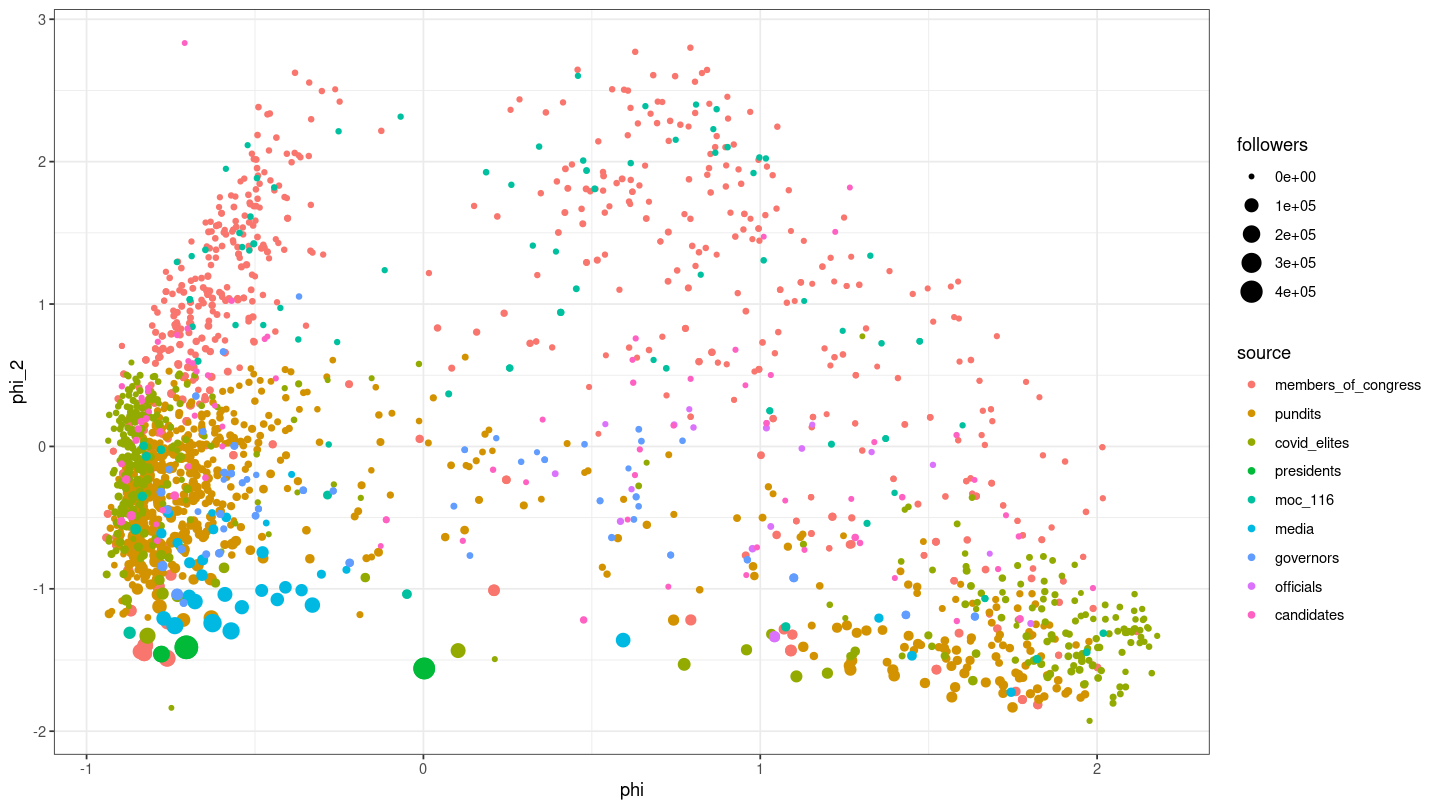

In [16]:
ggplot(elites, aes(x=phi, y=phi_2, color=source, size=followers)) + geom_point() + theme_bw()

The top/bottom 15 {MOCs,pundits,COVID elites}, by both first and second dimension.

In [17]:
elites %>% group_by(source) %>% slice_max(order_by = desc(phi), n = 15) %>% select(source, screen_name, phi, phi_2, followers)

source,screen_name,phi,phi_2,followers
<fct>,<chr>,<dbl>,<dbl>,<dbl>
members_of_congress,repcori,-0.9409746,-0.6407099,8543
members_of_congress,coribush,-0.9409746,-0.6407099,8543
members_of_congress,jamaalbowmanny,-0.9371243,-0.4736061,6021
members_of_congress,repbowman,-0.9371243,-0.4736061,6021
members_of_congress,repmondaire,-0.9204849,-0.0337187,2027
members_of_congress,mondairejones,-0.9204849,-0.0337187,2027
members_of_congress,reppressley,-0.9099783,-0.6892066,24226
members_of_congress,ayannapressley,-0.9099783,-0.6892066,24226
members_of_congress,repkatieporter,-0.9091345,-0.6392697,22934


In [18]:
elites %>% group_by(source) %>% slice_max(order_by = phi, n = 15) %>% select(source, screen_name, phi, phi_2, followers)

source,screen_name,phi,phi_2,followers
<fct>,<chr>,<dbl>,<dbl>,<dbl>
members_of_congress,ronnyjacksontx,2.117833,-1.301129974,1666
members_of_congress,repronnyjackson,2.117833,-1.301129974,1666
members_of_congress,repgregmurphy,2.016987,-0.364114485,291
members_of_congress,augustpfluger,2.015706,-0.005610037,84
members_of_congress,reppfluger,2.015706,-0.005610037,84
members_of_congress,burgessowens,2.001190,-1.552646987,4218
members_of_congress,repburgessowens,2.001190,-1.552646987,4218
members_of_congress,repandybiggsaz,1.988202,-1.138162550,3141
members_of_congress,laurenboebert,1.987278,-1.536378355,3971


In [19]:
elites %>% group_by(source) %>% slice_max(order_by = desc(phi_2), n = 15) %>% select(source, screen_name, phi, phi_2, followers)

source,screen_name,phi,phi_2,followers
<fct>,<chr>,<dbl>,<dbl>,<dbl>
members_of_congress,repmattgaetz,1.8238063,-1.814335,15289
members_of_congress,mattgaetz,1.8238063,-1.814335,15289
members_of_congress,repdevinnunes,1.7783308,-1.777815,14763
members_of_congress,devinnunes,1.7783308,-1.777815,14763
members_of_congress,jim_jordan,1.7587374,-1.720787,20601
members_of_congress,repdancrenshaw,1.5230663,-1.567556,22486
members_of_congress,dancrenshawtx,1.5230663,-1.567556,22486
members_of_congress,burgessowens,2.0011902,-1.552647,4218
members_of_congress,repburgessowens,2.0011902,-1.552647,4218


In [20]:
elites %>% group_by(source) %>% slice_max(order_by = phi_2, n = 15) %>% select(source, screen_name, phi, phi_2, followers)

source,screen_name,phi,phi_2,followers
<fct>,<chr>,<dbl>,<dbl>,<dbl>
members_of_congress,robert_aderholt,0.7925397,2.8000814,554
members_of_congress,replarrybucshon,0.6287206,2.7711294,520
members_of_congress,repmckinley,0.4577210,2.6451155,660
members_of_congress,repmikerogersal,0.8420522,2.6439951,549
members_of_congress,repmcnerney,-0.3812112,2.6239398,701
members_of_congress,congpalazzo,0.8268778,2.6220843,308
members_of_congress,repbilljohnson,0.6822894,2.6072280,766
members_of_congress,repbobgibbs,0.7472305,2.6001843,770
members_of_congress,austinscottga08,0.8061885,2.5611349,501


In [21]:
write_tsv(elites, "../data/elites_combined_with_phi.tsv")